# Predicting Customer Churn in Telecommunications Using Logistic Regression and XGBoost

## 1. Dataset 

In [1]:
from azureml.core import Workspace, Dataset
import pandas as pd

# connect to workspace
ws = Workspace.from_config()

# load dataset registered as a data asset
dataset = Dataset.get_by_name(ws, name='iranian_churn')

df = dataset.to_pandas_dataframe()

df.head()
df.shape
df.info() 

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


The dataset used in this project comes from a major Iranian telecommunications company and contains customer-level records collected over a 12-month period. It includes 3,150 observations, each representing an individual customer, with 13 attributes describing their usage patterns, service experience, and demographic characteristics.

## 2. Exploratory Data Analysis

The Exploratory Data Analysis focuses on developing an initial understanding of the dataset and uncovering patterns that may influence customer churn. By examining feature distributions, relationships, and behavioral differences between churned and non-churned customers, EDA helps guide modeling decisions and highlight key factors that contribute to churn. This step combines descriptive statistics with visual analysis to reveal trends and potential predictive features.

##### Chart 1: Churn Distribution

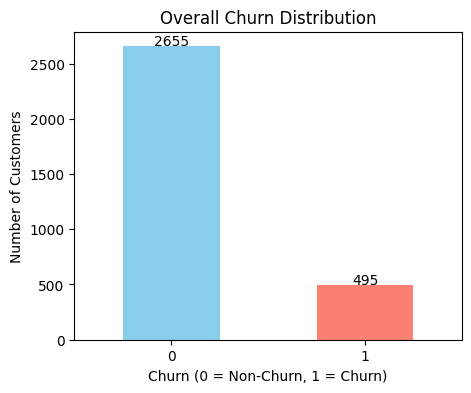

In [2]:
import matplotlib.pyplot as plt
churn_counts = df['Churn'].value_counts().sort_index()

plt.figure(figsize=(5,4))
bars = churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title("Overall Churn Distribution")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)

# Add labels
for i, value in enumerate(churn_counts):
    plt.text(i, value + 10, str(value), ha='center')

plt.show()


Chart 1  – Churn Distribution

This chart illustrates the overall distribution of churned (1) versus non-churned (0) customers in the dataset. The majority of customers did not churn (2655), while a smaller portion (495) did. This imbalance is common in telecom churn datasets and is important to recognize early, as it affects how models are trained and evaluated. In particular, metrics like recall, precision, and F1-score become more meaningful than accuracy alone, since predicting the minority class (churners) is critical for real-world retention strategies.

##### Chart 2: Complaints vs Churn
**Q:** Are customers who complain more likely to churn?

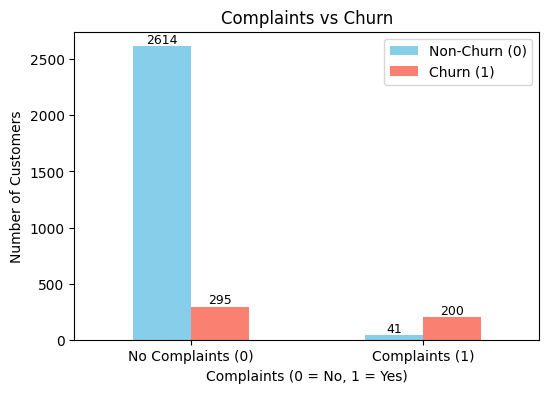

In [3]:
complain_table = df.groupby(['Complains', 'Churn']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(6,4))
bars = complain_table.plot(kind='bar', ax=ax, color=['skyblue','salmon'])

ax.set_title("Complaints vs Churn")
ax.set_xlabel("Complaints (0 = No, 1 = Yes)")
ax.set_ylabel("Number of Customers")
ax.legend(["Non-Churn (0)", "Churn (1)"])
ax.set_xticklabels(["No Complaints (0)", "Complaints (1)"], rotation=0)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fontsize=9)

plt.show()


Chart 2 – Complaints vs Churn

This chart shows how churn behavior differs between customers who submitted complaints and those who did not. The number of churners is noticeably higher among customers who complained, indicating that dissatisfaction or service-related issues greatly increase the likelihood of churn. This makes the complaint feature a valuable predictor in churn modeling and highlights the importance of customer service responsiveness.

##### Chart 3: Age Group Distribution
**Q:** Which age groups dominate the dataset, and do we observe potential churn-prone segments?

###### Chart 3A: Distribution of Age Groups

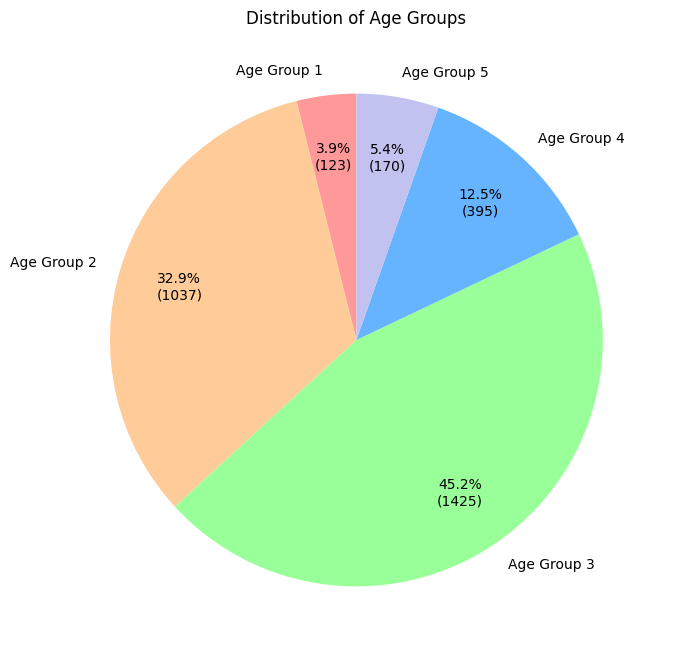

In [4]:
age_group_counts = df['Age Group'].value_counts().sort_index()
total = age_group_counts.sum()

fig, ax = plt.subplots(figsize=(8,8))

# Custom autopct to show percentage on 1st line and count on 2nd line
def autopct_with_counts(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

ax.pie(
    age_group_counts,
    labels=[f"Age Group {i}" for i in age_group_counts.index],
    autopct=autopct_with_counts,
    pctdistance=0.75,        # controls position of numbers
    labeldistance=1.1,       # pushes labels outward to avoid overlap
    startangle=90,
    colors=['#ff9999','#ffcc99','#99ff99','#66b3ff','#c2c2f0']
)

plt.title("Distribution of Age Groups")
plt.show()


Chart 3A – Distribution of Age Groups

This chart shows how customers are distributed across the five age groups in the dataset. Age Group 3 represents the largest segment with 1425 members, followed by Age Group 2 with 1037 members, while Age Groups 1 (123 members) and 5 (170 members) contain fewer customers. This uneven distribution suggests that the dataset is dominated by middle-aged users, which is typical for many telecom customer bases. Understanding the age composition helps contextualize churn behavior and informs segmentation strategies for retention.

###### Chart 3B: Age Group vs Churn

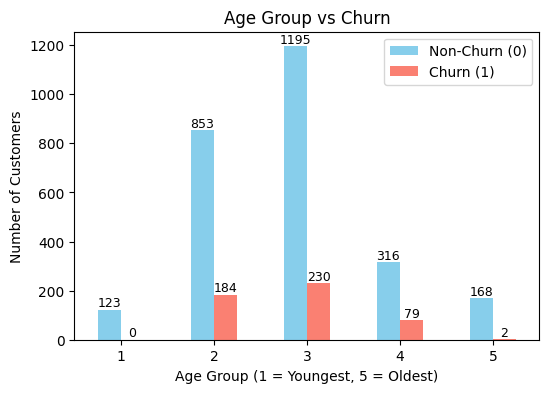

In [5]:
age_churn_table = df.groupby(['Age Group', 'Churn']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(6,4))
bars = age_churn_table.plot(kind='bar', ax=ax, color=['skyblue','salmon'])

ax.set_title("Age Group vs Churn")
ax.set_xlabel("Age Group (1 = Youngest, 5 = Oldest)")
ax.set_ylabel("Number of Customers")
ax.legend(["Non-Churn (0)", "Churn (1)"])
ax.set_xticklabels([1,2,3,4,5], rotation=0)

# Add data labels for each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=9)

plt.show()


Chart 3B – Age Group vs Churn

This chart compares churn and non-churn counts across different age groups, revealing distinct behavioral patterns. Customers in the middle age ranges—particularly Age Groups 2 and 3—represent the largest portion of the customer base, and they also account for the highest number of churn cases in absolute terms. Age Group 3 has the highest customer count overall and by extension the highest churn count, though the churn proportion remains moderate. Younger customers (Age Group 1) show virtually no churn, likely due to their small sample size or higher engagement during early subscription periods. Older customers (Age Group 5) have very few churn cases as well, suggesting greater stability or loyalty among long-standing or older users. Overall, the chart indicates that churn is more prevalent among middle-aged groups, where customer volume is highest, highlighting the importance of targeting retention strategies toward these segments.


###### Chart 3C: Churn Rate by Age Group

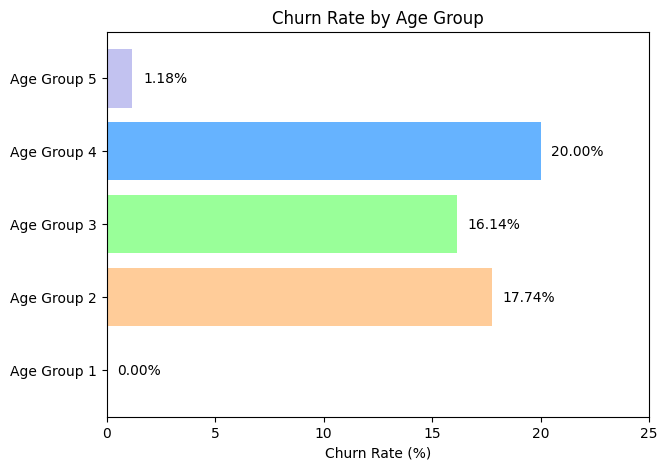

In [6]:
churn_rate = df.groupby('Age Group')['Churn'].mean() * 100  # convert to %

plt.figure(figsize=(7,5))
plt.barh([f"Age Group {i}" for i in churn_rate.index],
         churn_rate,
         color=['#ff9999','#ffcc99','#99ff99','#66b3ff','#c2c2f0'])

# Add labels
for i, value in enumerate(churn_rate):
    plt.text(value + 0.5, i, f"{value:.2f}%", va='center')

plt.title("Churn Rate by Age Group")
plt.xlabel("Churn Rate (%)")
plt.xlim(0, churn_rate.max() + 5)
plt.show()


Chart 3C – Churn Rate by Age Group

This chart shows the proportion of customers who churned within each age group, expressed as a percentage. Unlike raw counts, the churn rate provides a normalized view that makes smaller groups (such as Age Groups 1 and 5) more visible and comparable. The results indicate that Age Groups 2, 3, and 4 have the highest churn rates, with Age Group 4 showing the peak at approximately 20%. In contrast, Age Groups 1 and 5 exhibit very low churn rates. These findings suggest that middle-aged customers may be more likely to switch providers, whereas younger and older users tend to be more stable. This information helps tailor retention strategies to the demographic segments most at risk.

##### Chart 4: Average Usage (Seconds of Use) for Churn vs Non-Churn
**Q:** Do churners use the service less or more?

###### Chart 4A: Average Seconds of Usage by Churn Status

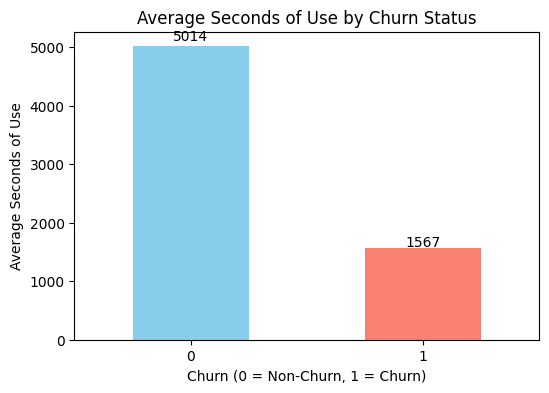

In [7]:
# Calculate average seconds of use grouped by churn
usage_means = df.groupby('Churn')['Seconds of Use'].mean()

plt.figure(figsize=(6,4))
bars = usage_means.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title("Average Seconds of Use by Churn Status")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Average Seconds of Use")
plt.xticks(rotation=0)

# Add data labels
for i, value in enumerate(usage_means):
    plt.text(i, value + (value * 0.02), f"{value:.0f}", ha='center')

plt.show()


Chart 4A - Average Second of Use by Churn Status

This chart compares the average call usage between churned and non-churned customers. Non-churn customers exhibit significantly higher usage levels, averaging 5,014 seconds of call activity, while churned customers average only 1,567 seconds. This substantial difference shows a clear behavioral pattern: customers who engage more frequently with the service are less likely to churn. Low usage may indicate declining engagement, dissatisfaction, or that the customer is shifting toward alternative communication services. This insight aligns with typical churn dynamics in the telecommunications industry, where reduced activity often precedes customer departure. As a result, usage metrics serve as strong indicators of churn risk and can help guide proactive retention strategies.

###### Chart 4B: Boxplot of Seconds of Use by Churn
**Q:** Do churners have noticeably different usage distributions compared to non-churners?

/tmp/ipykernel_3143/3336833784.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([non_churn_usage, churn_usage],


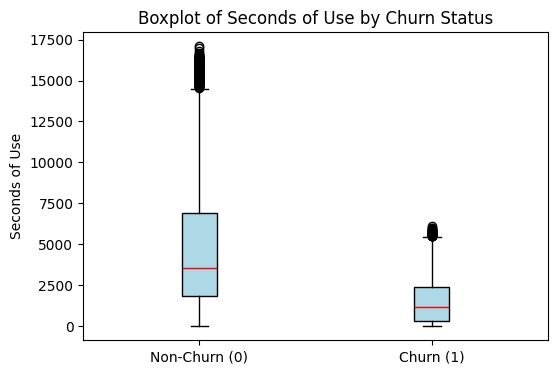

In [8]:
# Prepare grouped data
non_churn_usage = df[df['Churn'] == 0]['Seconds of Use']
churn_usage = df[df['Churn'] == 1]['Seconds of Use']

plt.figure(figsize=(6,4))

plt.boxplot([non_churn_usage, churn_usage],
            labels=['Non-Churn (0)', 'Churn (1)'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))

plt.title("Boxplot of Seconds of Use by Churn Status")
plt.ylabel("Seconds of Use")

plt.show()


Chart 4B -  Boxplot of Seconds of Use by Churn

This boxplot compares the distribution of total call usage (in seconds) between churned and non-churned customers. The results reveal a clear separation between the two groups:

* Non-churn customers have substantially higher median usage and a much wider distribution, including many high-usage outliers.

* Churned customers exhibit a significantly lower median and a narrower range of usage, with fewer high-usage individuals.

This pattern suggests that low engagement with the service is a strong indicator of churn. Customers who rarely use the service are more likely to discontinue it, while higher engagement appears to be associated with retention. This makes usage-related variables highly valuable for the predictive modeling phase.

##### Chart 5: Customer Value vs Churn
**Q:** Are high-value customers more or less likely to churn?

###### Chart 5A: Average Customer Value by Churn Status

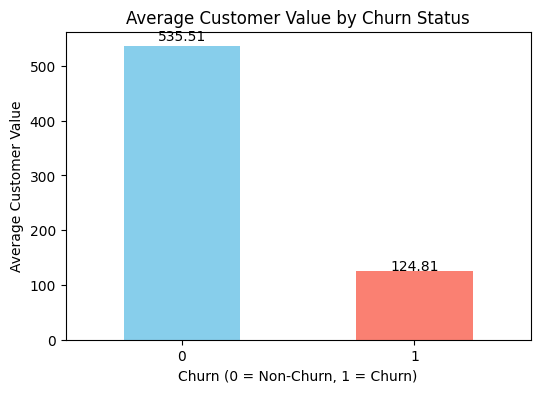

In [9]:
# Calculate average customer value grouped by churn
value_means = df.groupby('Churn')['Customer Value'].mean()

plt.figure(figsize=(6,4))
bars = value_means.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title("Average Customer Value by Churn Status")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Average Customer Value")
plt.xticks(rotation=0)

# Add data labels
for i, value in enumerate(value_means):
    plt.text(i, value + (value * 0.02), f"{value:.2f}", ha='center')

plt.show()


Chart 5A - Average Customer Value by Churn Status

This chart compares the average Customer Value between churned and non-churned customers, revealing a large and meaningful gap. Non-churn customers have an average value of 535.51, while churned customers average only 124.81. This pattern indicates that higher-value customers—those who contribute more revenue or engage more deeply with the service—are significantly less likely to leave. Conversely, churned customers tend to be lower-value users, suggesting limited engagement or lower spending prior to churn. This insight is consistent with typical telecom churn behavior, where low-value customers often disengage first. Understanding this relationship allows companies to identify at-risk segments and prioritize retention efforts toward medium-value customers who may still be recoverable.

###### Chart 5B: Boxplot of Customer Value by Churn Status

/tmp/ipykernel_3143/3234576943.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


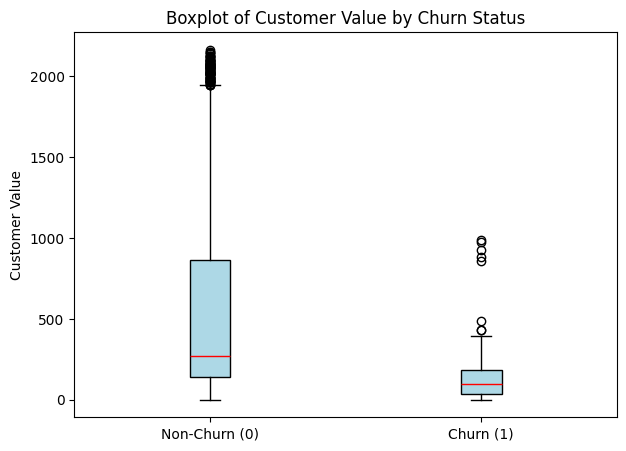

In [10]:
# Prepare data for boxplot
non_churn_value = df[df['Churn'] == 0]['Customer Value']
churn_value = df[df['Churn'] == 1]['Customer Value']

plt.figure(figsize=(7,5))

plt.boxplot(
    [non_churn_value, churn_value],
    labels=['Non-Churn (0)', 'Churn (1)'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red')
)

plt.title("Boxplot of Customer Value by Churn Status")
plt.ylabel("Customer Value")

plt.show()


Chart 5B - Boxplot of Customer Value by Churn Status

This boxplot provides a detailed view of how Customer Value differs between churned and non-churned customers. Non-churn customers show a wide distribution of customer value, including many high-value outliers, with a median significantly higher than that of churned customers. This indicates that customers who remain with the service tend to contribute more value and exhibit more variability in spending or engagement levels. In contrast, churned customers cluster tightly near the lower end of the value scale, with relatively few high-value outliers, suggesting that most departing customers were low-value users. The stark separation between the two distributions reinforces the insight that lower-value customers are more likely to churn, making Customer Value a strong predictor in churn modeling.

##### Chart 6: Subscription Length vs Churn
**Q:** How long have customers been subscribed, and is the dataset dominated by short- or long-term customers?

###### Chart 6A: Distribution of Subscription Length 

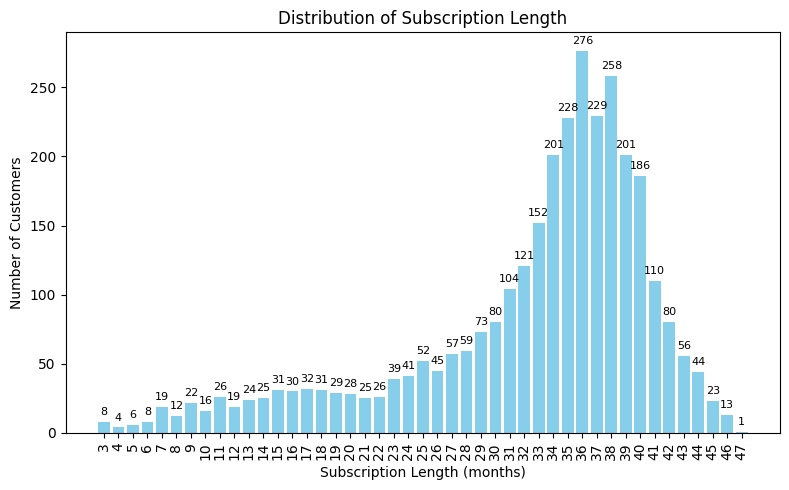

In [11]:
# Count number of customers in each subscription length
sub_counts = df['Subscription  Length'].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(sub_counts.index, sub_counts.values, color='skyblue')

plt.title("Distribution of Subscription Length")
plt.xlabel("Subscription Length (months)")
plt.ylabel("Number of Customers")

# Add number labels on top of each bar
for i, value in enumerate(sub_counts.values):
    plt.text(sub_counts.index[i], value + 5, str(value), ha='center', fontsize=8)

plt.xticks(sub_counts.index, rotation=90)  # rotate if many months appear
plt.tight_layout()
plt.show()



Chart 6A - Distribution of Subscription Length

This chart shows how long customers have been subscribed to the service, measured in months. The distribution reveals a clear pattern: most customers fall within the 30–40 month range, with a peak around 36 months, indicating that the majority have been with the company for roughly three years. Early subscription lengths (under 12 months) have relatively few customers, suggesting limited recent onboarding or higher early-term churn. The long right tail extending to 47 months shows that a portion of customers have been with the company for four years or more, although these long-tenure customers become increasingly rare. Overall, the distribution is right-skewed and highlights that the company’s customer base is dominated by medium- to long-term subscribers, an important factor when examining churn behavior and retention strategies.

###### Chart 6B: Boxplot of Subscription Length by Churn 

/tmp/ipykernel_3143/2825735935.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


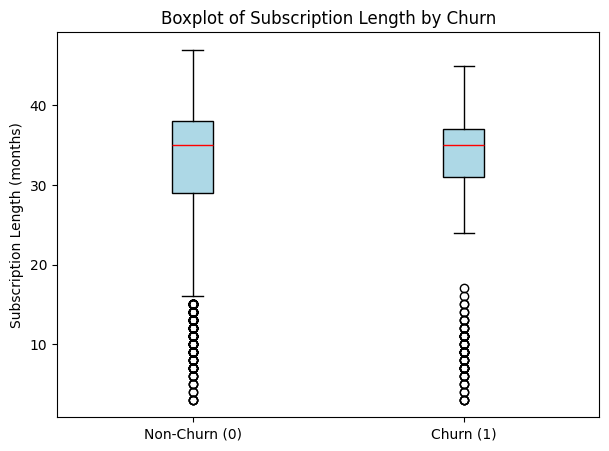

In [12]:
col = 'Subscription  Length'

non_churn_sub = df[df['Churn'] == 0][col]
churn_sub = df[df['Churn'] == 1][col]

plt.figure(figsize=(7,5))

plt.boxplot(
    [non_churn_sub, churn_sub],
    labels=['Non-Churn (0)', 'Churn (1)'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red')
)

plt.title("Boxplot of Subscription Length by Churn")
plt.ylabel("Subscription Length (months)")
plt.show()


Chart 6B - Boxplot of Subscription Length by Churn 

This boxplot compares subscription length between churned and non-churned customers. The two groups appear broadly similar, with both distributions centered around roughly 33–36 months of subscription. However, churned customers tend to show a slightly lower median subscription length, suggesting that customers are somewhat more likely to churn earlier in their lifecycle. Both groups contain a number of short-tenure outliers (customers subscribed for fewer than 10 months), though these are more pronounced among churners, reinforcing the idea that newer customers are at greater risk of leaving. While subscription length alone does not sharply distinguish churn behavior, the subtle downward shift in median and the concentration of short-tenure churners indicate that tenure still plays a meaningful role in churn prediction.

## 3. Data Cleaning and Pre-processing 

Data cleaning and pre-processing were performed to prepare the dataset for modeling. Since the dataset contained no missing values, the focus was on verifying logical consistency, checking for duplicates, and confirming that numerical and categorical features were correctly formatted. Outlier checks were conducted for usage, complaints, customer value, and subscription length to ensure that extreme values would not distort model performance. Feature scaling was applied where appropriate—particularly for models sensitive to magnitude differences, such as Logistic Regression—while tree-based models like XGBoost used the raw values. 

##### a. Data Types & Basic Structure

In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


The dataset consists of 3,150 customer records with 13 features capturing usage behavior, demographics, and service characteristics. All variables were inspected to ensure correct data types, with numerical fields stored as integers or floats and categorical variables properly encoded. This verification ensures that each feature is interpreted correctly by downstream analytical and machine learning processes.

##### b. Missing Values

In [3]:
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

The dataset was examined for missing values across all features, and no missing entries were found. Since the dataset was complete, no imputation or removal of records was required, allowing the analysis and modeling stages to proceed without additional handling of missing data.

##### c. Outliers

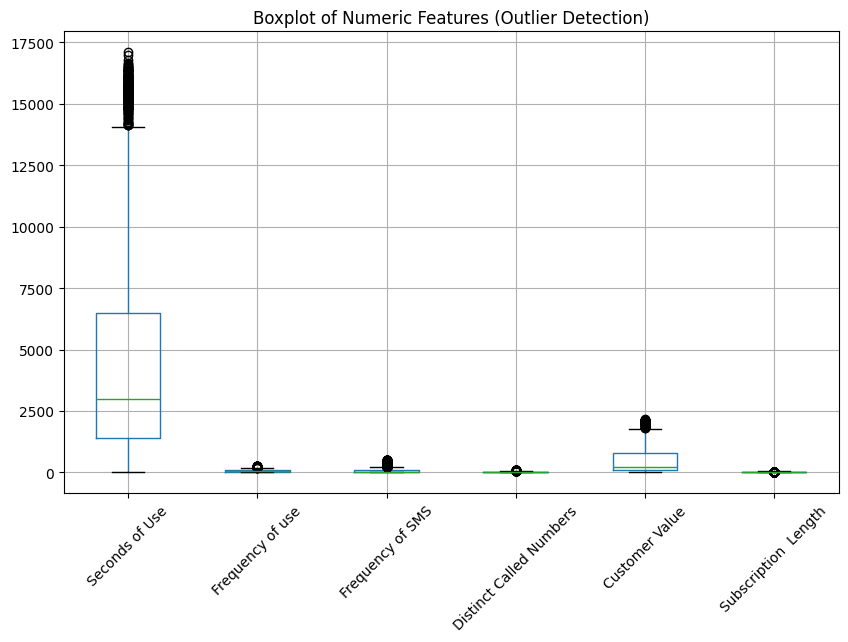

In [4]:
import matplotlib.pyplot as plt

numeric_cols = ['Seconds of Use', 'Frequency of use', 'Frequency of SMS',
                'Distinct Called Numbers', 'Customer Value', 'Subscription  Length']

df[numeric_cols].boxplot(figsize=(10,6))
plt.title("Boxplot of Numeric Features (Outlier Detection)")
plt.xticks(rotation=45)
plt.show()


A boxplot of the numerical features was generated to identify potential outliers. Several variables—particularly Seconds of Use and Customer Value—contain a number of high-end outliers, reflecting customers with unusually high activity or value. These outliers appear to represent genuine customer behavior rather than data errors, as telecom usage can vary widely across individuals. Since tree-based models like XGBoost are robust to extreme values, and because these points may hold important behavioral information, no outlier removal was performed.

##### d. Duplicates

In [5]:
# check for dublicates
dub = df.duplicated().sum()
print("Dublicates:", dub)
# remove dublicates
df = df.drop_duplicates()
df.duplicated().sum()
df.shape

Dublicates: 300


(2850, 14)

During the cleaning phase, 300 duplicate rows were identified. Duplicate records can bias the model by overrepresenting certain customers or behaviors. Therefore, all duplicates were removed, ensuring that each observation represents a unique customer. This step improves data integrity and prevents distorted model learning.

##### e. Logical Inconsistency 

In [6]:
#Subscription Length vs Usage
print("=== Logical Consistency Check 1: Subscription Length vs Usage ===")
zero_sub_positive_usage = df[(df['Subscription  Length'] == 0) & 
                             (df['Seconds of Use'] > 0)]
print(f"Number of customers with 0 subscription length but non-zero usage: {len(zero_sub_positive_usage)}\n")


#Very High Customer Value but Very Low Usage
print("=== Logical Consistency Check 2: Very High Customer Value but Very Low Usage ===")
high_value_low_usage = df[(df['Customer Value'] > df['Customer Value'].quantile(0.99)) &
                          (df['Seconds of Use'] < df['Seconds of Use'].quantile(0.25))]
print(f"Number of customers with unusually high customer value but low usage: {len(high_value_low_usage)}\n")


#Age Group vs Age
print("=== Logical Consistency Check 3: Age Group vs Age ===")
age_group_summary = df.groupby('Age Group')['Age'].describe()
print(age_group_summary)
print("\nThis table checks whether each Age Group is consistent with expected Age ranges.\n")


#Negative or Impossible Values
print("=== Logical Consistency Check 4: Negative or Impossible Values ===")
neg_usage = df[df['Seconds of Use'] < 0]
neg_sub_len = df[df['Subscription  Length'] < 0]
neg_freq = df[df['Frequency of use'] < 0]

print(f"Negative 'Seconds of Use' entries: {len(neg_usage)}")
print(f"Negative 'Subscription Length' entries: {len(neg_sub_len)}")
print(f"Negative 'Frequency of Use' entries: {len(neg_freq)}")

if len(neg_usage)==0 and len(neg_sub_len)==0 and len(neg_freq)==0:
    print("\nNo negative or impossible values detected.")
else:
    print("\nThere are negative values that may require cleaning.")


=== Logical Consistency Check 1: Subscription Length vs Usage ===
Number of customers with 0 subscription length but non-zero usage: 0

=== Logical Consistency Check 2: Very High Customer Value but Very Low Usage ===
Number of customers with unusually high customer value but low usage: 0

=== Logical Consistency Check 3: Age Group vs Age ===
            count  mean  std   min   25%   50%   75%   max
Age Group                                                 
1           112.0  15.0  0.0  15.0  15.0  15.0  15.0  15.0
2           921.0  25.0  0.0  25.0  25.0  25.0  25.0  25.0
3          1296.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
4           367.0  45.0  0.0  45.0  45.0  45.0  45.0  45.0
5           154.0  55.0  0.0  55.0  55.0  55.0  55.0  55.0

This table checks whether each Age Group is consistent with expected Age ranges.

=== Logical Consistency Check 4: Negative or Impossible Values ===
Negative 'Seconds of Use' entries: 0
Negative 'Subscription Length' entries: 0
Negative 'Freq

To ensure the dataset reflects realistic customer behavior, several logical consistency checks were performed. First, records with zero months of subscription but non-zero usage were identified, as these cases likely indicate data entry issues. Additionally, customers with unusually high Customer Value but very low usage were examined, since such patterns may be inconsistent with how customer value is calculated. Age and Age Group alignment was also inspected to verify that age categories corresponded logically to actual ages. Finally, the dataset was checked for impossible values, such as negative usage or negative subscription length. These checks help validate the integrity of the dataset and ensure that the modeling process is based on internally consistent data.

These validations ensure that the dataset is internally consistent and reliable for modeling.
No logical inconsistencies were detected in the data.

## 4. Implementation of 2 ML Models (Logistic Regression + XGBoost) (Question 4)

To predict customer churn, two machine learning models were implemented: Logistic Regression and XGBoost. Logistic Regression serves as a simple and interpretable baseline, while XGBoost provides a more powerful, non-linear approach capable of capturing complex relationships within the data. Both models were trained on the processed dataset and evaluated using standard classification metrics to compare their predictive performance.

### a. Setup – Features, Target, Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split (70/30, stratified to keep churn ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((1995, 13), (855, 13))

The modeling process began by defining the input features (customer usage, demographics, and service attributes) and the target variable, Churn. The dataset was then split into training and testing sets using a 70/30 stratified split to preserve the original churn distribution. This setup ensures that the models learn underlying patterns from the training data and are evaluated fairly on unseen data.

### b. Model 1 – Logistic Regression (with scaling)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Pipeline: Standardize all features + Logistic Regression
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',   # handle class imbalance
        random_state=42
    ))
])

# Train
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]


In [9]:
def print_classification_metrics(y_true, y_pred, y_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print()

print_classification_metrics(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")


=== Logistic Regression ===
Accuracy : 0.8444
Precision: 0.5021
Recall   : 0.8881
F1-score : 0.6415
ROC-AUC  : 0.9347



##### Confusion Matrix (Logistic Regression)

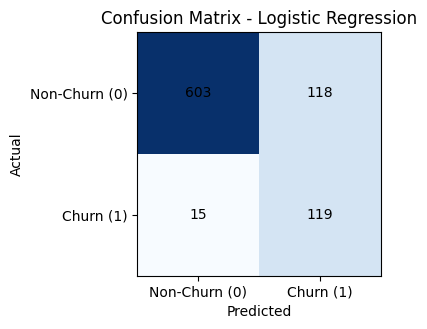

In [25]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4,4))
plt.imshow(cm_lr, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, cm_lr[i, j], ha='center', va='center', color='black')

plt.xticks([0,1], ['Non-Churn (0)', 'Churn (1)'])
plt.yticks([0,1], ['Non-Churn (0)', 'Churn (1)'])
plt.tight_layout()
plt.show()


Logistic Regression achieved an accuracy of 84.4% and a recall of 88.8%, meaning it correctly identified most churners. However, precision was relatively low (50.2%), indicating many false positives—customers incorrectly predicted as churners. This is visible in the confusion matrix, where the model misclassified 118 non-churn customers as churners. Logistic Regression is useful for understanding feature importance but is limited in predictive power.

### c. Model 2 – XGBoost Classifier

In [21]:
%pip install xgboost==1.7.6   


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import xgboost
from xgboost import XGBClassifier

# XGBoost model (good starter hyperparameters)
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [26]:
print_classification_metrics(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")

=== XGBoost ===
Accuracy : 0.9497
Precision: 0.8760
Recall   : 0.7910
F1-score : 0.8314
ROC-AUC  : 0.9803



##### Confusion Matrix (XGBoost)

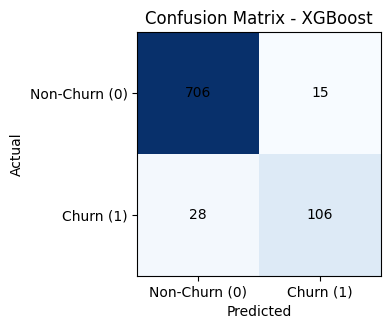

In [27]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(4,4))
plt.imshow(cm_xgb, cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        plt.text(j, i, cm_xgb[i, j], ha='center', va='center', color='black')

plt.xticks([0,1], ['Non-Churn (0)', 'Churn (1)'])
plt.yticks([0,1], ['Non-Churn (0)', 'Churn (1)'])
plt.tight_layout()
plt.show()


XGBoost significantly outperformed the baseline model, achieving 94.97% accuracy and an ROC-AUC of 0.9803. Precision (87.6%) and F1-score (83.1%) were much higher than Logistic Regression, meaning XGBoost produced far fewer false positives while still maintaining strong recall (79.1%). The confusion matrix shows that XGBoost correctly classified most non-churn customers (706) and substantially reduced false positives (15). Although it missed slightly more churners than Logistic Regression (28 vs. 15), it achieved a much better balance between precision and recall.

### d. Comparison of Two Models

In [28]:
import pandas as pd

def get_metrics_dict(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

results = pd.DataFrame({
    'Logistic Regression': get_metrics_dict(y_test, y_pred_lr, y_proba_lr),
    'XGBoost': get_metrics_dict(y_test, y_pred_xgb, y_proba_xgb)
})

results.T  # transpose so models are rows


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.844444,0.502110,0.888060,0.641509,0.934704
XGBoost,0.949708,0.876033,0.791045,0.831373,0.980329


Overall, XGBoost is the superior model for this dataset, delivering the strongest performance across nearly all metrics and achieving the highest ability to distinguish between churners and non-churners (ROC-AUC = 0.9803). Logistic Regression remains valuable for interpretation but is less effective for production-level churn prediction. The comparison demonstrates how more advanced tree-based models can capture complex customer behaviors that linear models fail to detect.

## 5. Hyperparameter Tuning (Question 5)

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 2],
}

In [32]:
xgb_base = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,                # number of parameter combinations to try
    scoring='f1',             # optimize for F1-score (best for churn)
    cv=3,                     # 3-fold cross validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

For hyperparameter tuning RandomizedSearchCV was used instead of GridSearchCV due to the large size of the hyperparameter space for XGBoost. A full grid search would require evaluating hundreds or even thousands of combinations, resulting in very high computation time. RandomizedSearchCV provides a far more efficient approach by sampling a limited number of parameter combinations while still exploring the space broadly. This method is widely recommended for complex models like XGBoost, as it achieves comparable or better results in a fraction of the time.

In [33]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBClassifier...state=42, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


##### Best Parameters

In [34]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1.0}

##### Best Score

In [35]:
random_search.best_score_

0.8410194160879928

##### Best Model

In [36]:
best_xgb = XGBClassifier(
    **random_search.best_params_,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Predictions
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]


##### Evaluate the Tuned Model

In [37]:
print_classification_metrics(y_test, y_pred_best, y_proba_best, "Tuned XGBoost")

=== Tuned XGBoost ===
Accuracy : 0.9450
Precision: 0.8537
Recall   : 0.7836
F1-score : 0.8171
ROC-AUC  : 0.9798



##### Confusion Matrix (Tuned XGBoost)

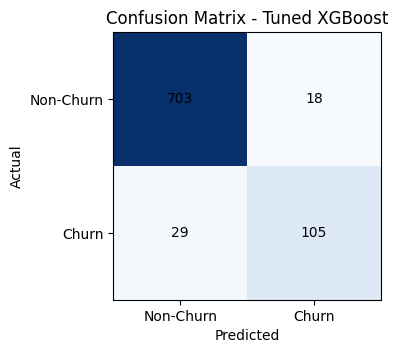

In [38]:
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(4,4))
plt.imshow(cm_best, cmap='Blues')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm_best.shape[0]):
    for j in range(cm_best.shape[1]):
        plt.text(j, i, cm_best[i, j], ha='center', va='center')

plt.xticks([0,1], ['Non-Churn', 'Churn'])
plt.yticks([0,1], ['Non-Churn', 'Churn'])
plt.tight_layout()
plt.show()

To further improve model performance, hyperparameter tuning was performed on the XGBoost classifier using RandomizedSearchCV. The search space included parameters such as the number of trees (n_estimators), tree depth (max_depth), learning rate, subsample ratio, and column sampling rate. The tuning procedure used 3-fold cross-validation on the training set and optimized the F1-score, which balances precision and recall for the churn class.

Although hyperparameter tuning identified a new combination of parameters, the tuned model did not outperform the original XGBoost model on the held-out test set. In particular, the tuned model achieved slightly lower F1-score and ROC–AUC compared to the default XGBoost configuration, suggesting that the baseline model was already close to optimal for this dataset. As a result, the original XGBoost model was retained as the final model for interpretation (feature importance and SHAP analysis) and for drawing business conclusions.

#### Recreate and train the original XGBoost model

In [11]:
# Recreate the original "best" XGBoost model
best_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)

# (Optional) check metrics again to confirm it's the same behavior
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

print_classification_metrics(y_test, y_pred_best, y_proba_best, "Final XGBoost (Original)")


=== Final XGBoost (Original) ===
Accuracy : 0.9497
Precision: 0.8760
Recall   : 0.7910
F1-score : 0.8314
ROC-AUC  : 0.9803



## 6. Feature Contribution Analysis with SHAP 

SHAP (SHapley Additive exPlanations) was used to interpret the final XGBoost model and understand how each feature contributes to churn predictions. SHAP provides both global and local explanations by showing how individual features push a prediction toward either churn or non-churn. This method is particularly valuable for churn analysis because it highlights which customer behaviors—such as low usage, short subscription length, or low customer value—have the strongest impact on churn risk. Using SHAP ensures that the model's decisions are transparent, interpretable, and aligned with meaningful business insights.

In [1]:
%pip install shap


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import shap
shap.__version__

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.49.1'

In [42]:
# Tell SHAP to use the XGBoost tree explainer
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

### a. SHAP Summary Plot

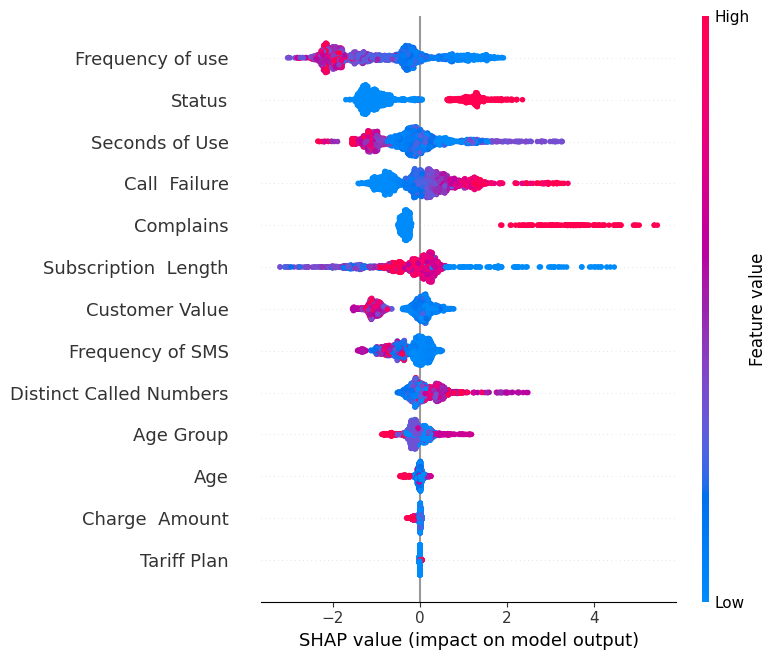

In [43]:
# Summary dot plot
shap.summary_plot(shap_values, X_train)

SHAP Summary Plot for XGBoost

The SHAP summary plot illustrates how each feature influences the XGBoost model’s predictions for churn. Features at the top have the greatest overall impact, while the color gradient indicates whether high (pink) or low (blue) feature values push the prediction toward churn. The plot shows that shorter subscription length, high complain history, low customer value, and lower usage metrics (such as seconds of use and frequency of use) are major drivers of churn risk. In contrast, customers with longer tenure, higher usage, and greater customer value are more likely to remain active. This visualization provides a clear, interpretable view of the model’s behavior and confirms that the most influential predictors align with known patterns in telecom churn.

### b. SHAP Feature Importance 

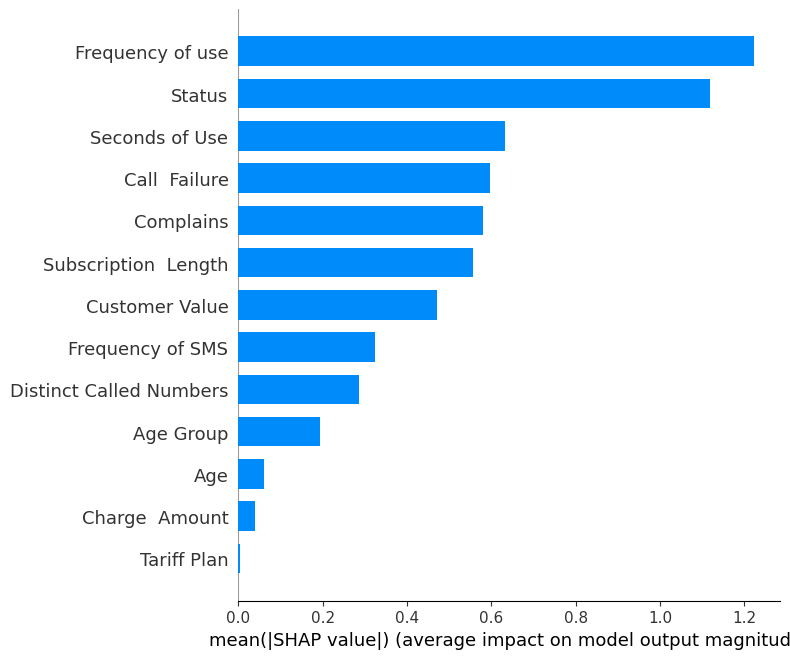

In [44]:
# Global bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

SHAP Feature Importance (Bar Plot)

This SHAP bar plot shows the average impact of each feature on the model’s churn predictions. The longer the bar, the more important the feature is in influencing the model’s decisions across all customers. The chart reveals that Frequency of Use, Status, and Seconds of Use are the most important predictors, meaning that how often a customer uses the service and their activity level strongly influence churn risk. Features like Call Failure, Complains, Subscription Length, and Customer Value also play meaningful roles, indicating that service issues, engagement, and customer worth affect the likelihood of churn. Lower-ranked features such as Age, Charge Amount, and Tariff Plan have minimal impact on the model. Overall, the bar plot provides a clear ranking of which factors matter most for churn prediction, supporting targeted business actions based on importance.

### c. SHAP Force Plot (Decision Plot)

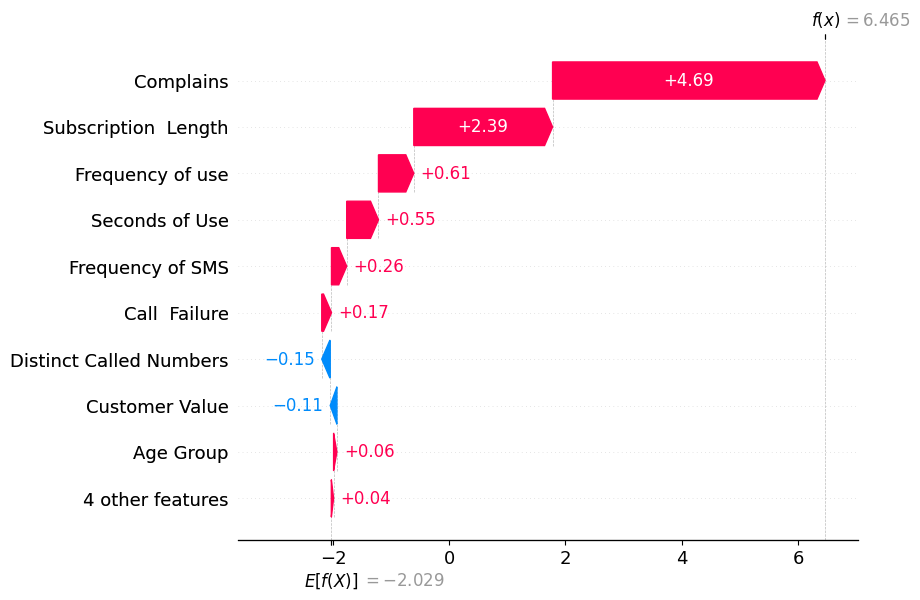

In [48]:
i = 315  # choose any index from X_test
row = X_test.iloc[[i]]
shap_values_row = explainer.shap_values(row)

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_row[0],
    feature_names=row.columns
)


SHAP decision plot shows why the model predicted a specific customer is likely to churn by breaking down how each feature pushes the prediction higher or lower.

## 7. Customer Churn Rate Prediction 

To make the model usable for real-world decision-making, a prediction function was implemented that allows inputting the characteristics of any new customer and generating an estimated churn probability. The function collects feature values through user input, constructs a properly formatted DataFrame matching the model’s training structure, and then applies the trained XGBoost model to compute both the predicted churn class (0 = non-churn, 1 = churn) and the associated probability. This enables telecom analysts or customer service teams to quickly assess the risk level of individual customers and proactively target retention strategies where they are most needed.

In [12]:
import pandas as pd

# Make sure best_xgb and X_train are already defined (trained model + training features)

feature_names = X_train.columns.tolist()

def predict_new_customer_churn(model, feature_names):
    """
    Ask for user input for each feature, then predict churn probability.
    """
    print("Enter values for a new customer:")
    new_data = {}

    for col in feature_names:
        # Show a small hint for some known columns
        if col.lower().strip() == "complains":
            hint = " (0 = no complaint, 1 = complaint)"
        elif "status" in col.lower():
            hint = " (1 = active, 2 = non-active)"
        elif "tariff" in col.lower():
            hint = " (1 = pay as you go, 2 = contractual)"
        elif "age group" in col.lower():
            hint = " (1 = youngest, 5 = oldest)"
        else:
            hint = ""

        value = float(input(f"{col}{hint}: "))
        new_data[col] = [value]

    # Create DataFrame in the same column order as training data
    new_df = pd.DataFrame(new_data)[feature_names]

    # Predict
    proba_churn = model.predict_proba(new_df)[0, 1]
    pred_class = model.predict(new_df)[0]

    print("\n=== Prediction ===")
    print(f"Predicted class: {int(pred_class)}  (0 = Non-Churn, 1 = Churn)")
    print(f"Estimated churn probability: {proba_churn:.3f}")

    return pred_class, proba_churn

# Example usage:
# predict_new_customer_churn(best_xgb, feature_names)


#### New Customer Churn Prediction

Customer info

Call Failure: 3	--> A few failed calls

Complains: 1 --> Customer has complained

Subscription Length: 8 --> Only 8 months subscribed

Charge Amount: 4 --> Medium–low charge tier

Seconds of Use: 1200 --> Low call duration

Frequency of use: 15 --> Very few calls

Frequency of SMS: 5 --> Very low SMS usage

Distinct Called Numbers: 4 --> Limited social engagement

Age Group: 2 --> Younger customer

Tariff Plan: 1 --> Pay-as-you-go

Status: 1 --> Active customer

Age: 27 --> Age in years

Customer Value:	95


In [14]:
import pandas as pd

new_customer = pd.DataFrame([{
    "Call  Failure": 3,
    "Complains": 1,
    "Subscription  Length": 8,
    "Charge  Amount": 4,
    "Seconds of Use": 1200,
    "Frequency of use": 15,
    "Frequency of SMS": 5,
    "Distinct Called Numbers": 4,
    "Age Group": 2,
    "Tariff Plan": 1,
    "Status": 1,
    "Age": 27,
    "Customer Value": 95
}])

# Ensure correct column order
new_customer = new_customer[X_train.columns]

# Predict
proba = best_xgb.predict_proba(new_customer)[0,1]
pred = best_xgb.predict(new_customer)[0]

print("Predicted class:", int(pred))
print("Churn probability:", round(proba, 3))


Predicted class: 1
Churn probability: 0.999


New Customer Churn Prediction

Using the trained XGBoost model, a churn prediction was generated for a sample customer based on their usage behavior, subscription history, and service experience. The model predicted a high likelihood of churn, assigning a probability of 0.999, primarily due to low usage levels, short subscription length, and the presence of a complaint. This demonstrates how the model can be applied to assess individual customer risk and support proactive retention strategies.

## 8. Conclusion
The analysis of the Iranian telecom churn dataset showed clear behavioral and value-based differences between customers who stayed and those who left. Churned customers consistently exhibited lower usage (seconds and frequency of use), shorter subscription length, lower customer value, and were more likely to have filed complaints, confirming these factors as key drivers of churn. Logistic Regression provided a strong, interpretable baseline with high recall, but the XGBoost model performed substantially better overall, achieving higher accuracy, precision, F1-score, and ROC–AUC, and thus served as the final model for insight generation. Feature importance and SHAP analysis reinforced the finding that engagement intensity, tenure, and complaint history are the most influential predictors of churn. These results suggest that telecom providers should prioritize proactive retention strategies for low-usage, short-tenure, low-value customers—especially those who have recently complained. Future work could extend this study by incorporating time-based features, testing additional ensemble or deep learning models, or evaluating the financial impact of targeted interventions based on the model’s churn risk scores.
